In [1]:
from brian2 import *
from scipy.stats import pearsonr
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

# Main Params
N_E = 4000
N_I = 1000

p_con = 0.2 # Probability of connection, currently sets all possible connections
drive_I = 22000 # Total drive for inhibitory population
drive_E = 24000 # Total drive for excitatory population

# voltage
V_L = -70. * mV # Resting potential
V_thr = -52. * mV  # Threshold for firing
V_reset = -59. * mV  # Resest voltage
V_E = 0 * mV  # Reversal potential excitatory
V_I = -70. * mV  # Reversal potential inhibitory

# refractory period
ref_E = 2. * ms
ref_I = 1. * ms

# external stimuli 
C_ext = 800  # Number of inputs
total_input_I = int(drive_I / C_ext)
rate_I = total_input_I * Hz

total_input_E = int(drive_E / C_ext)
rate_E = total_input_E * Hz

# Membrane time constants for I and E
tau_m_I = 10 * ms
tau_m_E = 20 * ms

# Conductances for interneurons
g_GABA_I = 4 * nS 
g_AMPA_I = 0.3 * nS 
g_NMDA_I = 0.1 * nS
g_AMPA_ext_I = 0.31 * nS

# Conductances for excitatory
g_GABA_E = 2.5 * nS
g_AMPA_E = 0.19 * nS
g_NMDA_E = 0.06 * nS
g_AMPA_ext_E = 0.3 * nS

# Time constants for GABA
tau_d_GABA = 5 * ms
tau_r_GABA = 0.5 * ms
tau_l_GABA = 0.5 * ms

# Time constants for poisson inputs
tau_d_Ext = 2 * ms
tau_r_Ext = 0.5 * ms
tau_l_Ext = 1 * ms

# Time constants for AMPA
tau_d_AMPA = 2 * ms
tau_r_AMPA = 0.4 * ms
tau_l_AMPA = 1 * ms

# Time constants for NMDA
tau_d_NMDA = 100 * ms
tau_r_NMDA = 2 * ms
tau_l_NMDA = 1 * ms

# Conductance and Membrane Leak (for correct units)
c_m_I = 0.2 * nF #0.2 * nF
g_m_I = 20 * nS #20. * nS
c_m_E = 0.5 * nF #0.5 * nF
g_m_E = 25 * nS #25. * nS

eqs_I = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_Ext + I_AMPA + I_GABA: amp 

I_GABA =  g_GABA_I * (v - V_I) * s_GABA : amp
I_AMPA =  g_AMPA_I * (v - V_E) * s_AMPA : amp
I_Ext =  g_AMPA_ext_I * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*c_a-s_AMPA)/tau_d_AMPA : 1
dc_a/dt = -c_a/tau_r_AMPA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p_I-s_Ext)/tau_d_Ext : 1
dc_p_I/dt = -c_p_I/tau_r_Ext : 1
'''

eqs_E = '''
dv/dt = (-g_m_E * (v - V_L) - I_syn) / c_m_E : volt (unless refractory)

I_syn = I_Ext + I_AMPA + I_GABA: amp 

I_GABA =  g_GABA_E * (v - V_I) * s_GABA : amp
I_AMPA =  g_AMPA_E * (v - V_E) * s_AMPA : amp
I_Ext =  g_AMPA_ext_E * (v - V_E) * s_Ext : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*c_g-s_GABA)/tau_d_GABA : 1
dc_g/dt = -c_g/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*c_a-s_AMPA)/tau_d_AMPA : 1
dc_a/dt = -c_a/tau_r_AMPA : 1

ds_Ext/dt = ((tau_r_Ext / tau_d_Ext) ** 
             (tau_d_Ext / (tau_r_Ext - tau_d_Ext))*c_p_E-s_Ext)/tau_d_Ext : 1
dc_p_E/dt = -c_p_E/tau_r_Ext : 1
'''

# Build my neurons and set initial values
P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=ref_I, method='euler')
P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=ref_E, method='euler')
P_I.v = V_L
P_E.v = V_L

# Add poisson, AMPA-like drive
P_D_I = PoissonInput(P_I, 'c_p_I', C_ext, rate_I, '1')
P_D_E = PoissonInput(P_E, 'c_p_E', C_ext, rate_E, '1')

# Synaptic equations
pre_GABA = '''
c_g += 1
'''

pre_AMPA = '''
c_a += 1
'''

# Build your synapses
C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_E = Synapses(P_I, P_E, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_E_I = Synapses(P_E, P_I, on_pre=pre_AMPA, method='euler', delay=tau_l_AMPA)

# Connect your synapses
C_I_I.connect(condition='i != j', p=p_con)
C_I_E.connect(p=p_con)
C_E_I.connect(p=p_con)

s_I = SpikeMonitor(P_I)
s_E = SpikeMonitor(P_E)
M = StateMonitor(P_I, ('I_GABA', 'I_AMPA', 's_GABA'), record=True)
p_I = PopulationRateMonitor(P_I)
p_E = PopulationRateMonitor(P_E)

net = Network(P_I, P_E, P_D_I, P_D_E, C_I_I, C_I_E, C_E_I, s_I, s_E, p_I, p_E, M)
net.run(2.5 * second, report='stdout')


Starting simulation at t=0. s for a duration of 2.5 s
2.3478000000000003 (93%) simulated in 10s, estimated 1s remaining.
2.5 (100%) simulated in 10s


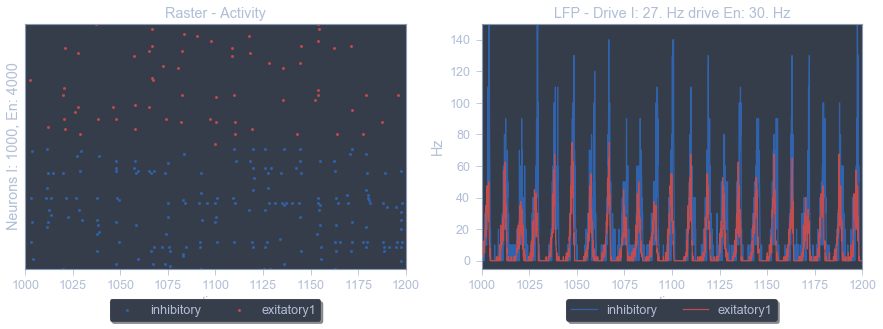

In [6]:
inhib_c = '#3063ab'
exct1_c = '#c24c4e' 
exct2_c = '#c2684c' 
exct3_c = '#c24c89' 
face = '#363d4a'

figure(figsize=(15, 5))
subplot(121)
plt.scatter(s_I.t / ms, s_I.i, color= inhib_c, marker ='.', label='inhibitory')
plt.scatter(s_E.t / ms, (s_E.i + N_I), color= exct1_c, marker ='.', label='exitatory1')
yticks([])
title('Raster - Activity')
xlabel('ms')
xlabel('time')
ylabel('Neurons I: ' + str(N_I) + ', En: ' + str(N_E))
ax = plt.gca()
box = ax.get_position()
ax.set_facecolor(face)
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
xlim([1000, 1200])
ylim([N_I-50, N_I+50])

subplot(122)
# plot_max = np.max(p_I.smooth_rate(width=0.01 * ms)[1000:1200] / Hz)
plt.plot(p_I.t / ms, p_I.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= inhib_c, label='inhibitory')
plt.plot(p_E.t / ms, p_E.smooth_rate(window='flat', width=0.10 * ms) / Hz, color= exct1_c, label='exitatory1')
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
title('LFP - Drive I: ' + str(rate_I) + ' drive En: ' + str(rate_E))
xlabel('ms')
xlabel('time')
ylabel('Hz')
# ylim((-5 , plot_max + (0.2*plot_max)))
xlim([1000, 1200])
ylim([-5, 150])
ax = plt.gca()
ax.set_facecolor(face)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])


# plt.text(1025, plot_max + (0.025*plot_max), 'g_ext_I: ' + str(g_AMPA_ext_I / nS) + 'nS' , fontsize=16)
# plt.text(1025,  plot_max - (0.1*plot_max) , 'g_ext_E: ' + str(g_AMPA_ext_E / nS) + 'nS' , fontsize=16)



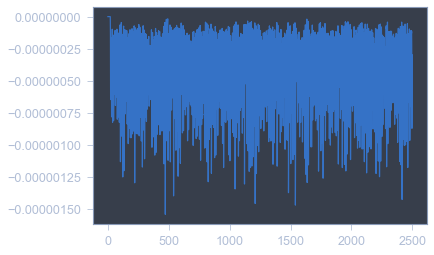

In [2]:
plot(M.t/ms, M.I_AMPA[0] /mA)

In [9]:
s_I.i

<spikemonitor.i: array([112, 342, 299, ..., 756, 475, 584])>